In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy
import os
from IPython.display import Audio
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
import bisect
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
# Dictionary for audio data

Audiodata = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'label': []}

In [4]:
# Real Cough Timestamps of the Data

def get_real_timestamps(cough_timestamp):

    timestamp = []
    f = open(cough_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append(float(line.split("\t")[0]))
    
    return timestamp

In [5]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [6]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [7]:
# Moving Average of the Data

def compute_moving_average(data, window_size=15):
    
    moving_averages = []

    i = 0
    while i < len(data) - window_size + 1:
        
        window = data[i : i + window_size]
        window_average = round(np.sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1    
    
    return np.array(moving_averages)

In [8]:
def binary_search(auc_values, threshold):
    index = bisect.bisect_left(auc_values, threshold)
    if index < len(auc_values):
        return index
    return None

In [9]:
# Cough Audio Percentile Calculation

audio_files = os.listdir('../records')
timestamp_files = os.listdir('../timestamps')
all_timestamp_data = dict()

per_25_data = []
per_50_data = []
per_75_data = []
per_90_data = []

# Filtering irrelevant files
audio_files = list(filter(lambda x: x.endswith('.wav'), audio_files))
timestamp_files = list(filter(lambda x: x.endswith('.txt'), timestamp_files))
# Getting cough detection results
for file in audio_files:

    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = '../records/' + file
    timestamp_path = '../timestamps/' + timestamp_data + '-label.txt'

    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)    
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    normalized_moving_avg_data = normalize_data(moving_avg_data)
    
    
    # *******************************
    # Find coughs in the data
    copy_data = moving_avg_data.copy()
    coughs = []

    i = 1
    for timestamp in real_timestamps:

        start = int((timestamp - 0.2) * sample_rate)
        finish = int((timestamp + 0.2) * sample_rate)

        data = copy_data[start:finish]
        coughs.append(data)

    # *******************************
    
    # *******************************
    # Find percentile points
    i = 1

    coughs_ftt = []
    for cough in coughs:
        # Removing DC component
        cough -= np.mean(cough)

        # Calculating Fast Fourier Transform
        X = np.fft.fft(cough)
        X_mag = np.abs(X) / len(cough)

        freqs = np.fft.fftfreq(len(cough), d=1/sample_rate)

        # Graph
        positive_freq_indices = np.where(freqs >= 0)

        # Getting positive part
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]

        # Adding to the list
        coughs_ftt.append((freqs, X_mag))

        auc = simps(X_mag, freqs)
        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Cumulative area
        cumulative_auc = [simps(X_mag[:i+1], freqs[:i+1]) for i in range(len(freqs))]

        # Find the indices for each percentile
        point_1 = binary_search(cumulative_auc, per_25)
        point_2 = binary_search(cumulative_auc, per_50)
        point_3 = binary_search(cumulative_auc, per_75)
        point_4 = binary_search(cumulative_auc, per_90)

        per_25_data.append(freqs[point_1])
        per_50_data.append(freqs[point_2])
        per_75_data.append(freqs[point_3])
        per_90_data.append(freqs[point_4])
        
        
        Audiodata['percentile_25'].append(freqs[point_1])
        Audiodata['percentile_50'].append(freqs[point_2])
        Audiodata['percentile_75'].append(freqs[point_3])
        Audiodata['percentile_90'].append(freqs[point_4])
        Audiodata['label'].append('cough')


    i += 1
    # *******************************

In [10]:
# No Cough Audio Percentile Calculation
i = 0
audio_files = os.listdir('../no-cough')
timestamp_files = os.listdir('../no-cough-timestamps')
all_timestamp_data = dict()

no_cough_per_25_data = []
no_cough_per_50_data = []
no_cough_per_75_data = []
no_cough_per_90_data = []

# Filtering irrelevant files
audio_files = list(filter(lambda x: x.endswith('.wav'), audio_files))
timestamp_files = list(filter(lambda x: x.endswith('.txt'), timestamp_files))
# Getting cough detection results
for file in audio_files:

    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = '../no-cough/' + file
    timestamp_path = '../no-cough-timestamps/' + timestamp_data + '-label.txt'
    
    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)    
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    normalized_moving_avg_data = normalize_data(moving_avg_data)
    
    # *******************************
    # Find coughs in the data
    copy_data = moving_avg_data.copy()
    peaks = []

    i = 1
    for timestamp in real_timestamps:

        start = int((timestamp - 0.2) * sample_rate)
        finish = int((timestamp + 0.2) * sample_rate)

        data = copy_data[start:finish]
        peaks.append(data)

    # *******************************
    
    # *******************************
    # Find percentile points
    i = 1

    peaks_ftt = []
    for peak in peaks:
        # Removing DC component
        peak -= np.mean(peak)

        # Calculating Fast Fourier Transform
        X = np.fft.fft(peak)
        X_mag = np.abs(X) / len(peak)

        peak_freqs = np.fft.fftfreq(len(peak), d=1/sample_rate)

        # Graph
        positive_freq_indices = np.where(peak_freqs >= 0)

        # Getting positive part
        peak_freqs = peak_freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]

        # Adding to the list
        peaks_ftt.append((peak_freqs, X_mag))

        auc = simps(X_mag, peak_freqs)
        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Cumulative area
        cumulative_auc = [simps(X_mag[:i+1], peak_freqs[:i+1]) for i in range(len(peak_freqs))]

        # Find the indices for each percentile
        point_1 = binary_search(cumulative_auc, per_25)
        point_2 = binary_search(cumulative_auc, per_50)
        point_3 = binary_search(cumulative_auc, per_75)
        point_4 = binary_search(cumulative_auc, per_90)
    
        no_cough_per_25_data.append(peak_freqs[point_1])
        no_cough_per_50_data.append(peak_freqs[point_2])
        no_cough_per_75_data.append(peak_freqs[point_3])
        no_cough_per_90_data.append(peak_freqs[point_4])
        
        Audiodata['percentile_25'].append(freqs[point_1])
        Audiodata['percentile_50'].append(freqs[point_2])
        Audiodata['percentile_75'].append(freqs[point_3])
        Audiodata['percentile_90'].append(freqs[point_4])
        Audiodata['label'].append('other')
        
    i += 1

    # *******************************

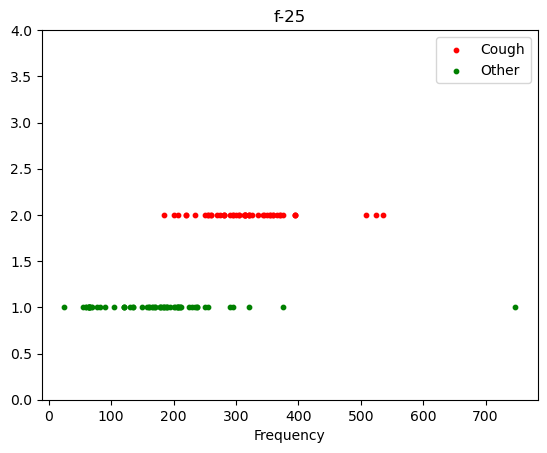

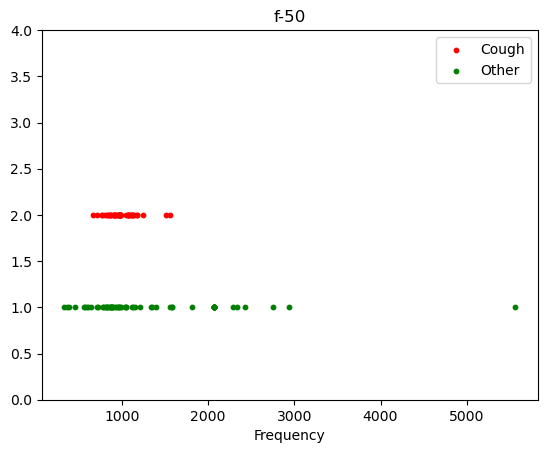

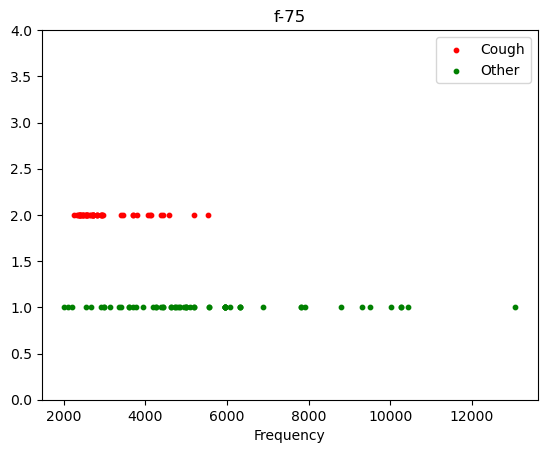

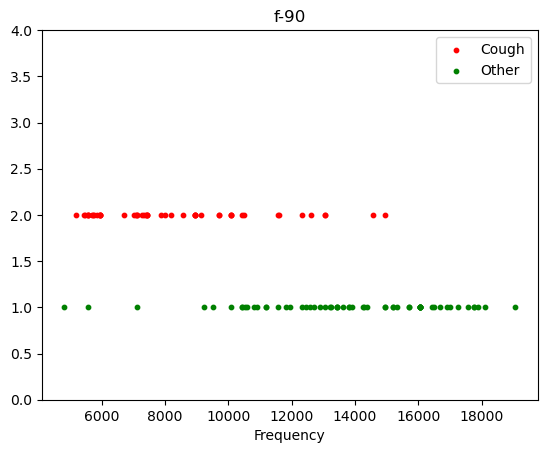

In [11]:
# PLOT OF COUGH AND NO COUGH

# 25 percentile

# Cough
i = 0
for point in per_25_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point in no_cough_per_25_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-25")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()

# 50 percentile 

# Cough

i = 0
for point in per_50_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
    
# No Cough

i = 0
for point in no_cough_per_50_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)
        
    i += 1
    
    
plt.title("f-50")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()


# 75 percentile

# Cough

i = 0
for point in per_75_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)
        
    i += 1
    

# No Cough

i = 0
for point in no_cough_per_75_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-75")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()
# 90 percentile

# Cough

i = 0
for point in per_90_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough

i = 0
for point in no_cough_per_90_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1
    
plt.title("f-90")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()

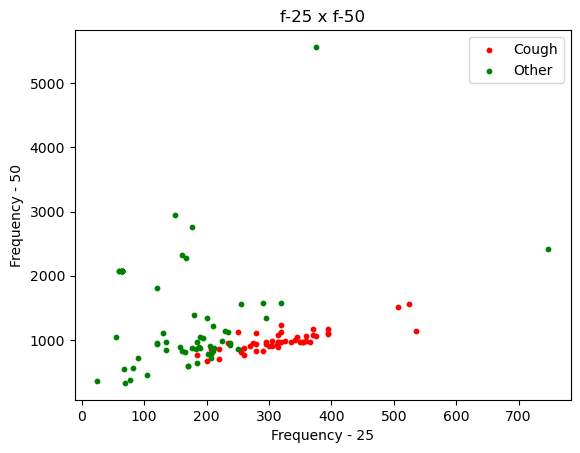

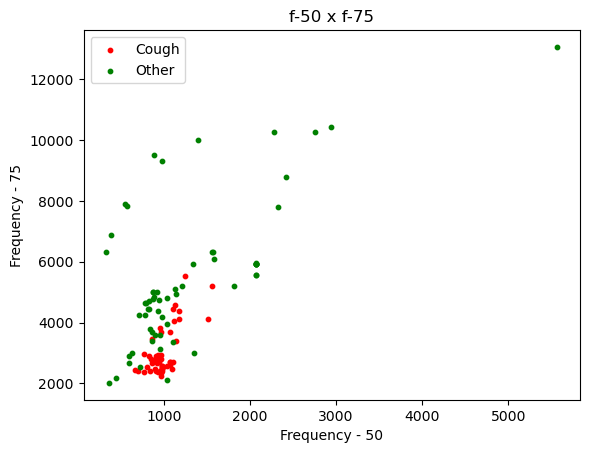

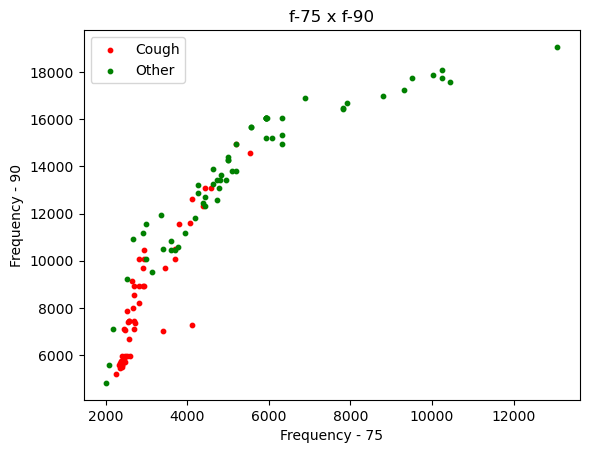

In [12]:
# 2 Dimensional Graphs


# 25 percentile x 50 percentile

# Cough
i = 0
for point1, point2 in zip(per_25_data, per_50_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_25_data, no_cough_per_50_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-25 x f-50")
plt.xlabel("Frequency - 25")
plt.ylabel("Frequency - 50")
plt.legend()
plt.show()


# 50 percentile x 75 percentile

# Cough
i = 0
for point1, point2 in zip(per_50_data, per_75_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_50_data, no_cough_per_75_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-50 x f-75")
plt.xlabel("Frequency - 50")
plt.ylabel("Frequency - 75")
plt.legend()
plt.show()

# 75 percentile x 90 percentile

# Cough
i = 0
for point1, point2 in zip(per_75_data, per_90_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_75_data, no_cough_per_90_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-75 x f-90")
plt.xlabel("Frequency - 75")
plt.ylabel("Frequency - 90")
plt.legend()
plt.show()

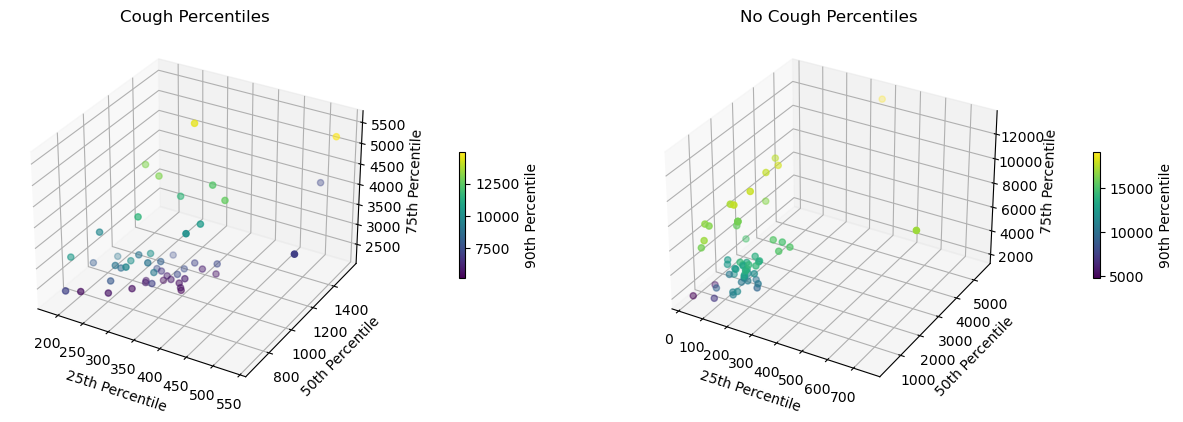

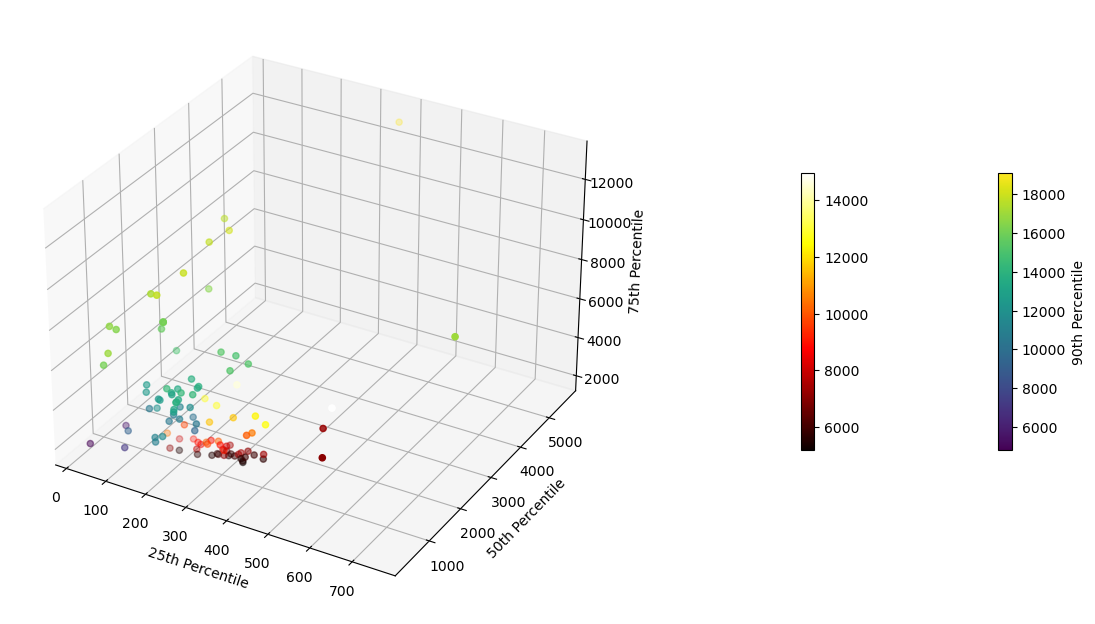

In [13]:
# 4 Dimensional Graph

# Cough Graph
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(221, projection='3d')

img = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data)
ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar = fig.colorbar(img, shrink=0.3, pad=0.15)
colorbar.set_label('90th Percentile')
plt.title("Cough Percentiles")


# No Cough Graph

ax = fig.add_subplot(222, projection='3d')

img = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar.set_label('90th Percentile')
colorbar = fig.colorbar(img, shrink=0.3, pad=0.15)
colorbar.set_label('90th Percentile')
plt.title("No Cough Percentiles")
plt.show()

# Combinations

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

img_1 = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
colorbar_1 = fig.colorbar(img_1, ax=[ax], shrink=0.3)
colorbar_1.set_label('90th Percentile')


img_2 = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data, cmap=plt.hot())
colorbar_2 = fig.colorbar(img_2, ax=[ax], shrink=0.3, pad=0.20)

ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar.set_label('90th Percentile')

plt.show()

In [ ]:
# MFCC Feature Extraction
















In [14]:
# Converting the Audiodata dictionary to pandas dataframe

df = pd.DataFrame.from_dict(Audiodata)
print(df.head())

   percentile_25  percentile_50  percentile_75  percentile_90  label
0          305.0          980.0         2575.0         7440.0  cough
1          315.0          970.0         2815.0         8190.0  cough
2          290.0          835.0         2400.0         5565.0  cough
3          395.0         1095.0         2485.0         5705.0  cough
4          360.0          980.0         2535.0         5940.0  cough


In [15]:
# file_labels include the file name, percentile and labels of the audio record
# Labels are cough or other
# Data is split as train data and test data

X = df.iloc[:, :4]
y = df.iloc[:, 4:5]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 3, test_size= 0.2)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

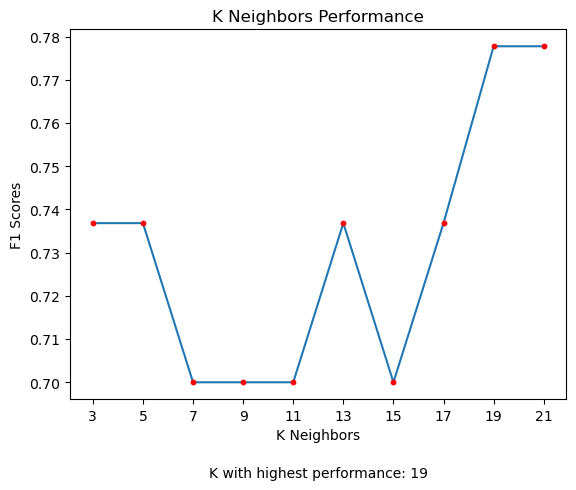

In [16]:
# Define the model

K = 3 # Initial value of K
max_K = len(y_test)

k_values = []
f1_scores = []

while K < max_K:
    classifier = KNeighborsClassifier(K, p=2, metric='euclidean')
    classifier.fit(X_train, y_train)

    # Predict the test set results

    y_pred = classifier.predict(X_test)

    # F1 score
    f1 = f1_score(y_test, y_pred, pos_label='cough')
    
    k_values.append(K)
    f1_scores.append(f1)

    K += 2
    
index = f1_scores.index(np.max(f1_scores))
best_k_value = k_values[index]

plt.plot(k_values, f1_scores)
plt.xlabel('K Neighbors')
plt.ylabel('F1 Scores')
plt.title('K Neighbors Performance')
plt.xticks(k_values)
for k, f1 in zip(k_values, f1_scores):   
    plt.scatter(k, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'K with highest performance: ' + str(best_k_value), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

In [17]:
# Evaluate Model

classifier = KNeighborsClassifier(n_neighbors=19, p=2, metric='euclidean')
classifier.fit(X_train, y_train)

# Predict the test set results

y_pred = classifier.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='cough')
print(cm)
print("\nF1_score: " + str(round(f1,3)))

# [[tp, fp]
# [fn, tn]]

[[ 7  2]
 [ 2 11]]

F1_score: 0.778
